In [1]:
# SVM reliability diagram
from sklearn.datasets import make_classification
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from matplotlib import pyplot
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

In [13]:
from collections import defaultdict
from sklearn.metrics import (
    brier_score_loss,
    f1_score,
    log_loss,
    precision_score,
    recall_score,
    roc_auc_score,
)

scores = defaultdict(list)

## Калибровка без `predict_proba`

In [2]:
X, y = make_classification(
    n_samples = 12000, # количество сэмплов
    n_features = 30, # количество функций
    n_informative = 20, # количество информ. функций
    n_redundant = 10, # количество избыточных функций
    weights = [.10, .1], # пропорции сэмплов для каждого класса
    random_state = 42) # генерация случайных чисел

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

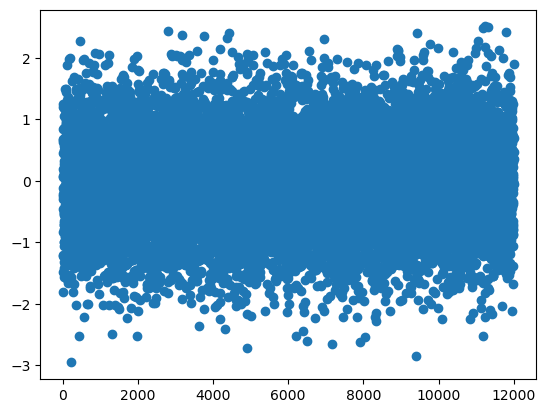

In [4]:
lin_svc = LinearSVC(dual = 'auto')
lin_svc.fit(X_train,y_train)
res = lin_svc.decision_function(X)
plt.scatter(range(len(res)),res);

In [5]:
class NaivelyCalibratedLinearSVC(LinearSVC):
    """LinearSVC с `predict_proba` метод простого перемасштабирования
    `decision_function` для бинарной классивикации."""

    def fit(self, X, y):
        super().fit(X, y)
        df = self.decision_function(X)
        self.df_min_ = df.min()
        self.df_max_ = df.max()

    def predict_proba(self, X):
        """Min-max перемасштабирование `decision_function` в диапазон [0, 1]."""
        df = self.decision_function(X)
        calibrated_df = (df - self.df_min_) / (self.df_max_ - self.df_min_)
        proba_pos_class = np.clip(calibrated_df, 0, 1)
        proba_neg_class = 1 - proba_pos_class
        proba = np.c_[proba_neg_class, proba_pos_class]
        return proba

In [6]:
lr = NaivelyCalibratedLinearSVC(dual="auto")
lr.fit(X_train,y_train)
lr.predict_proba(X_train)

array([[0.32275001, 0.67724999],
       [0.44042293, 0.55957707],
       [0.07392162, 0.92607838],
       ...,
       [0.61311958, 0.38688042],
       [0.61799396, 0.38200604],
       [0.61856991, 0.38143009]])

In [7]:
class NaivelyCalibratedSVC(SVC):
    """LinearSVC с `predict_proba` метод простого перемасштабирования
    `decision_function` для бинарной классивикации."""

    def fit(self, X, y):
        super().fit(X, y)
        df = self.decision_function(X)
        self.df_min_ = df.min()
        self.df_max_ = df.max()

    def predict_proba(self, X):
        """Min-max перемасштабирование `decision_function` в диапазон [0, 1]."""
        df = self.decision_function(X)
        calibrated_df = (df - self.df_min_) / (self.df_max_ - self.df_min_)
        proba_pos_class = np.clip(calibrated_df, 0, 1)
        proba_neg_class = 1 - proba_pos_class
        proba = np.c_[proba_neg_class, proba_pos_class]
        return proba

In [8]:
svc = NaivelyCalibratedSVC(kernel='rbf')
svc.fit(X_train,y_train)
svc.predict_proba(X_train)

array([[0.44373378, 0.55626622],
       [0.42091436, 0.57908564],
       [0.12887521, 0.87112479],
       ...,
       [0.6604152 , 0.3395848 ],
       [0.62844586, 0.37155414],
       [0.80239798, 0.19760202]])

### Пример калибровки LinearSVC

In [14]:
lr = LogisticRegression(C=1.0)

lr_svc = NaivelyCalibratedLinearSVC(dual="auto")
lr_svc_isotonic = CalibratedClassifierCV(lr_svc, cv=2, method="isotonic")
lr_svc_sigmoid = CalibratedClassifierCV(lr_svc, cv=2, method="sigmoid")

clf_list = [
    (lr, "Logistic"),
    (lr_svc, "LinearSVC"),
    (lr_svc_isotonic, "LinearSVC + Isotonic"),
    (lr_svc_sigmoid, "LinearSVC + Sigmoid"),
]

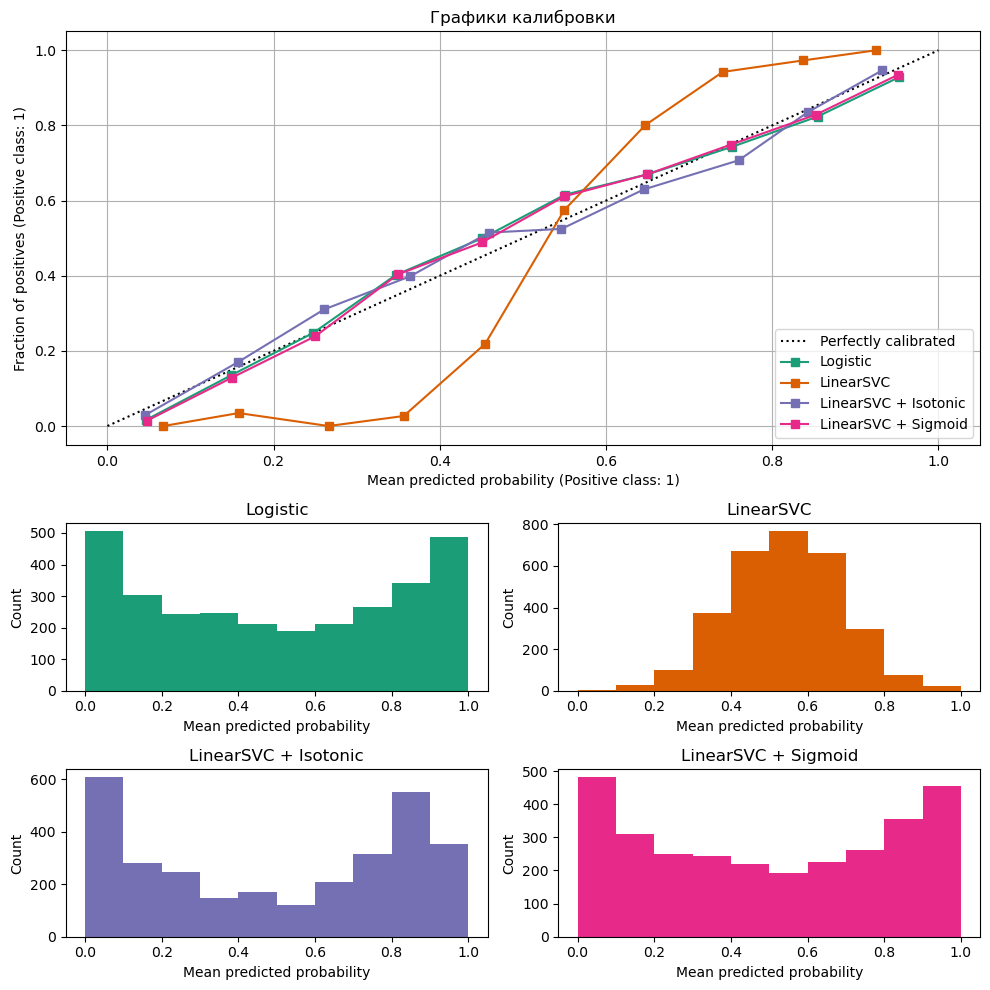

In [15]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Графики калибровки")

# Гистограммы
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()


In [16]:
scores = defaultdict(list)
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    scores["Classifier"].append(name)

    for metric in [brier_score_loss, log_loss, roc_auc_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_prob[:, 1]))

    for metric in [precision_score, recall_score, f1_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_pred))

    score_df = pd.DataFrame(scores).set_index("Classifier")
    score_df.round(decimals=3)

score_df

,Brier loss,Log loss,Roc auc,Precision,Recall,F1
Classifier,,,,,,
Logistic,0.141633,0.435991,0.878560,0.795044,0.791333,0.793184
LinearSVC,0.181362,0.547546,0.878353,0.795455,0.793333,0.794393
LinearSVC + Isotonic,0.141757,0.445109,0.877745,0.782581,0.808667,0.795410
LinearSVC + Sigmoid,0.141633,0.435739,0.878534,0.794649,0.792000,0.793322


### Пример калибровки SVC

In [17]:
lr = LogisticRegression(C=1.0)

svc = NaivelyCalibratedSVC()
svc_isotonic = CalibratedClassifierCV(lr, cv=2, method="isotonic")
svc_sigmoid = CalibratedClassifierCV(lr, cv=2, method="sigmoid")

clf_list = [
    (lr, "Logistic"),
    (svc, "SVC"),
    (svc_isotonic, "SVC + Isotonic"),
    (svc_sigmoid, "SVC + Sigmoid"),
]

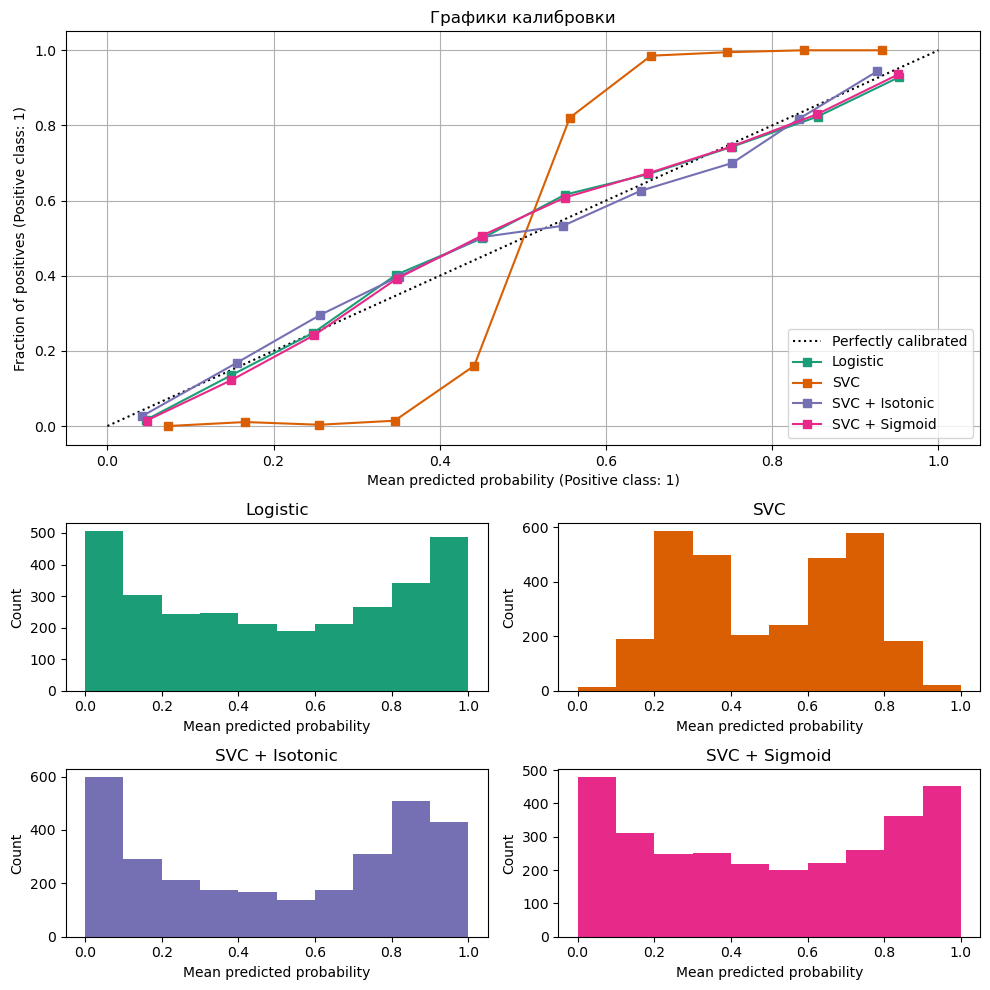

In [18]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Графики калибровки")

# Гистограммы
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

In [19]:
scores = defaultdict(list)
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    scores["Classifier"].append(name)

    for metric in [brier_score_loss, log_loss, roc_auc_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_prob[:, 1]))

    for metric in [precision_score, recall_score, f1_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_pred))

    score_df = pd.DataFrame(scores).set_index("Classifier")
    score_df.round(decimals=3)

score_df

,Brier loss,Log loss,Roc auc,Precision,Recall,F1
Classifier,,,,,,
Logistic,0.141633,0.435991,0.878560,0.795044,0.791333,0.793184
SVC,0.101879,0.372824,0.991958,0.964877,0.970667,0.967763
SVC + Isotonic,0.141504,0.444375,0.878159,0.782274,0.812000,0.796860
SVC + Sigmoid,0.141541,0.435651,0.878733,0.793980,0.791333,0.792654
